<a href="https://colab.research.google.com/github/Ryzon3/csci_6967/blob/main/homework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports and some of following code referenced from: https://github.com/Uzmamushtaque/Projects-in-Machine-Learning-and-AI/blob/main/TitanicExample.ipynb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

# **Dataset for whole HW**

For this question I am going to use [100 Sports Image Classification](https://www.kaggle.com/datasets/gpiosenka/sports-classification) from kaggle.

I will begin with EDA and preprocessing

In [ ]:
import kagglehub

# Login to kaggle
kagglehub.login()

# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)

100%|██████████| 424M/424M [00:20<00:00, 21.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/sports-classification/versions/9


## **Exploratory Data Analysis**

In [ ]:
# Load dataset test, train, valid from folders using Pytorch ImageFolder
from torchvision.datasets import ImageFolder
train = ImageFolder(path + '/train')
valid = ImageFolder(path + '/valid')
test = ImageFolder(path + '/test')
print(train.classes)

['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'roller 

In [ ]:
from collections import Counter

train_targets = [train.targets[i] for i in range(len(train))]
class_counts = Counter(train_targets)
print("Class Distribution (Train):")
for class_index, count in class_counts.items():
    print(f"{train.classes[class_index]}: {count}")

Class Distribution (Train):
air hockey: 112
ampute football: 112
archery: 132
arm wrestling: 99
axe throwing: 113
balance beam: 147
barell racing: 123
baseball: 174
basketball: 169
baton twirling: 108
bike polo: 110
billiards: 145
bmx: 140
bobsled: 138
bowling: 120
boxing: 116
bull riding: 149
bungee jumping: 125
canoe slamon: 164
cheerleading: 131
chuckwagon racing: 120
cricket: 129
croquet: 134
curling: 141
disc golf: 123
fencing: 135
field hockey: 157
figure skating men: 128
figure skating pairs: 151
figure skating women: 157
fly fishing: 134
football: 191
formula 1 racing: 190
frisbee: 131
gaga: 118
giant slalom: 150
golf: 157
hammer throw: 122
hang gliding: 121
harness racing: 147
high jump: 158
hockey: 172
horse jumping: 134
horse racing: 139
horseshoe pitching: 102
hurdles: 136
hydroplane racing: 108
ice climbing: 130
ice yachting: 112
jai alai: 132
javelin: 136
jousting: 118
judo: 150
lacrosse: 151
log rolling: 128
luge: 127
motorcycle racing: 132
mushing: 111
nascar racing: 18

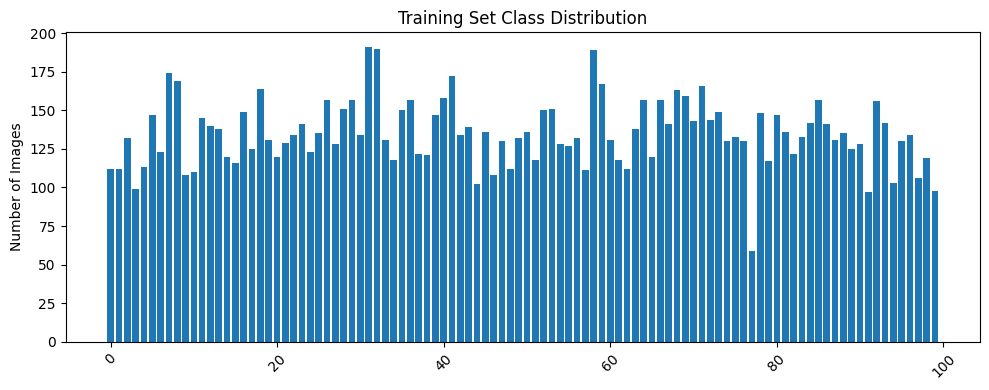

In [ ]:
# Plotting the class distribution in the training set
plt.figure(figsize=(10, 4))
classes = [i for i in range(len(class_counts.keys()))]
counts = list(class_counts.values())
plt.bar(classes, counts)
plt.ylabel('Number of Images')
plt.title('Training Set Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

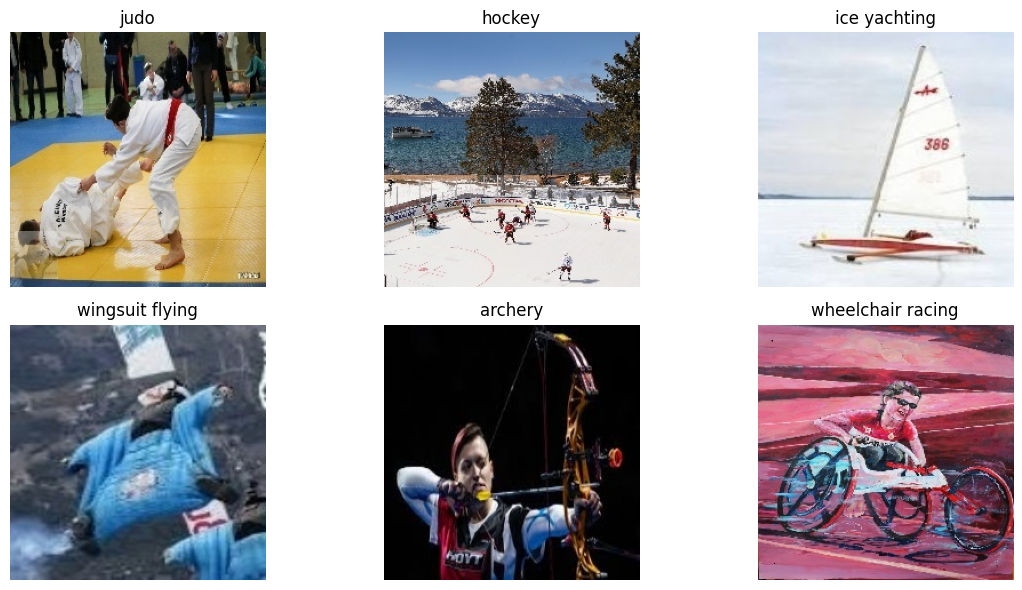

In [ ]:
from torchvision import transforms
import random
transform = transforms.ToTensor()

# Function to show an image from the dataset
def show_image(img, title=None):
    # Convert tensor image to numpy image for display
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Display a few random sample images from the training set with labels
sample_indices = random.sample(range(len(train)), 6)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(sample_indices):
    img, label = train[idx]
    plt.subplot(2, 3, i+1)
    # Apply transform
    img = transform(img)
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)
    plt.title(train.classes[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

We can see the dataset is some high quality images about sports! The classes are pretty evenly distributed and should be good for this task. We will now continue to the homework.

# **Task 1**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Data transforms & loading
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# Define a simple CNN
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28*128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

train = ImageFolder(path + '/train', transform=transform)
valid = ImageFolder(path + '/valid', transform=transform)
test = ImageFolder(path + '/test', transform=transform)
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(valid, batch_size=32)
test_loader = DataLoader(test, batch_size=32)

num_classes = len(train.classes)
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_epoch(model, loader):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*images.size(0)
    return running_loss/len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return correct/len(loader.dataset)

for epoch in range(10):
    train_loss = train_epoch(model, train_loader)
    acc = evaluate(model, val_loader)
    print(f'Epoch {epoch+1}: Loss = {train_loss:.4f}, Val Acc = {acc:.4f}')

# Eval on test set
test_acc = evaluate(model, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')


Using device: cuda
Epoch 1: Loss = 4.1883, Val Acc = 0.1340
Epoch 2: Loss = 3.1731, Val Acc = 0.3060
Epoch 3: Loss = 2.3299, Val Acc = 0.3760
Epoch 4: Loss = 1.5830, Val Acc = 0.3700
Epoch 5: Loss = 0.8494, Val Acc = 0.3620
Epoch 6: Loss = 0.3492, Val Acc = 0.3120
Epoch 7: Loss = 0.1609, Val Acc = 0.3420
Epoch 8: Loss = 0.1028, Val Acc = 0.3240
Epoch 9: Loss = 0.1056, Val Acc = 0.3440
Epoch 10: Loss = 0.1206, Val Acc = 0.2980
Test Accuracy: 0.3480


The model seemed to improve accuracy as training went on. Although 38% might not seem impressive but with how many classes there are I think this did quite well for such a simple model.

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load pretrained ResNet50 and modify final layer
resnet = models.resnet50(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False  # freeze feature extractor
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)
resnet = resnet.to(device)

optimizer_tl = optim.Adam(resnet.fc.parameters(), lr=0.001)

def train_epoch_tl(model, loader):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_tl.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_tl.step()
        running_loss += loss.item()*images.size(0)
    return running_loss/len(loader.dataset)

# Train the resnet model
for epoch in range(10):
    train_loss = train_epoch_tl(resnet, train_loader)
    acc = evaluate(resnet, val_loader)
    print(f'[TL] Epoch {epoch+1}: Loss = {train_loss:.4f}, Val Acc = {acc:.4f}')


# Eval on test set
test_acc = evaluate(resnet, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')


[TL] Epoch 1: Loss = 1.7113, Val Acc = 0.8600
[TL] Epoch 2: Loss = 0.6099, Val Acc = 0.8700
[TL] Epoch 3: Loss = 0.4255, Val Acc = 0.9000
[TL] Epoch 4: Loss = 0.3384, Val Acc = 0.8960
[TL] Epoch 5: Loss = 0.2905, Val Acc = 0.8980
[TL] Epoch 6: Loss = 0.2407, Val Acc = 0.9060
[TL] Epoch 7: Loss = 0.2145, Val Acc = 0.9020
[TL] Epoch 8: Loss = 0.1884, Val Acc = 0.9100
[TL] Epoch 9: Loss = 0.1630, Val Acc = 0.9120
[TL] Epoch 10: Loss = 0.1594, Val Acc = 0.9080
Test Accuracy: 0.9320


Using the pretrained model and applying transfer learning to this task was a great idea. The results from this were much better than training our CNN from the ground up. I think this is due to the model being much larger but already being trained making it efficient to use for this task.

In [ ]:
aug_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
])

aug_train_dataset = ImageFolder(path + '/train', transform=aug_transform)
# Create an augmented dataset by duplicating the data with transforms
aug_train_loader = DataLoader(aug_train_dataset, batch_size=32, shuffle=True)

# Reinitialize and train the same CNN on augmented data:
model_aug = CNN(num_classes)
model_aug = model_aug.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

# Training loop
def train_epoch_aug(model, loader):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_aug.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_aug.step()
        running_loss += loss.item()*images.size(0)
    return running_loss/len(loader.dataset)

for epoch in range(10):
    train_loss = train_epoch_aug(model_aug, aug_train_loader)
    acc = evaluate(model_aug, val_loader)
    print(f'[Aug] Epoch {epoch+1}: Loss = {train_loss:.4f}, Val Acc = {acc:.4f}')

# Eval on test set
test_acc = evaluate(model_aug, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

[Aug] Epoch 1: Loss = 4.3168, Val Acc = 0.0740
[Aug] Epoch 2: Loss = 3.6617, Val Acc = 0.1700
[Aug] Epoch 3: Loss = 3.1734, Val Acc = 0.2720
[Aug] Epoch 4: Loss = 2.8453, Val Acc = 0.3320
[Aug] Epoch 5: Loss = 2.6355, Val Acc = 0.3480
[Aug] Epoch 6: Loss = 2.4555, Val Acc = 0.3980
[Aug] Epoch 7: Loss = 2.3382, Val Acc = 0.4000
[Aug] Epoch 8: Loss = 2.2144, Val Acc = 0.4280
[Aug] Epoch 9: Loss = 2.1112, Val Acc = 0.4320
[Aug] Epoch 10: Loss = 2.0155, Val Acc = 0.4720
Test Accuracy: 0.4900


The results in this part 3 were much better than part 1. This shows that data augmentation helped with this problem. This likely shows that for this task the data was not enough to fit a model well. Through these transforms we could supplement the data to get better results.

# **Task 2**

Using device: cuda
[VAE] Epoch 1: Loss = 495.4672
[VAE] Epoch 2: Loss = 355.6168
[VAE] Epoch 3: Loss = 335.1343
[VAE] Epoch 4: Loss = 331.7848
[VAE] Epoch 5: Loss = 329.9479
[VAE] Epoch 6: Loss = 328.8510
[VAE] Epoch 7: Loss = 327.6502
[VAE] Epoch 8: Loss = 326.9164
[VAE] Epoch 9: Loss = 325.9135
[VAE] Epoch 10: Loss = 324.7616
[VAE] Epoch 11: Loss = 323.3409
[VAE] Epoch 12: Loss = 321.8403
[VAE] Epoch 13: Loss = 320.8373
[VAE] Epoch 14: Loss = 319.8736
[VAE] Epoch 15: Loss = 319.1673
[VAE] Epoch 16: Loss = 318.3069
[VAE] Epoch 17: Loss = 317.7169
[VAE] Epoch 18: Loss = 317.1268
[VAE] Epoch 19: Loss = 316.4166
[VAE] Epoch 20: Loss = 316.1628


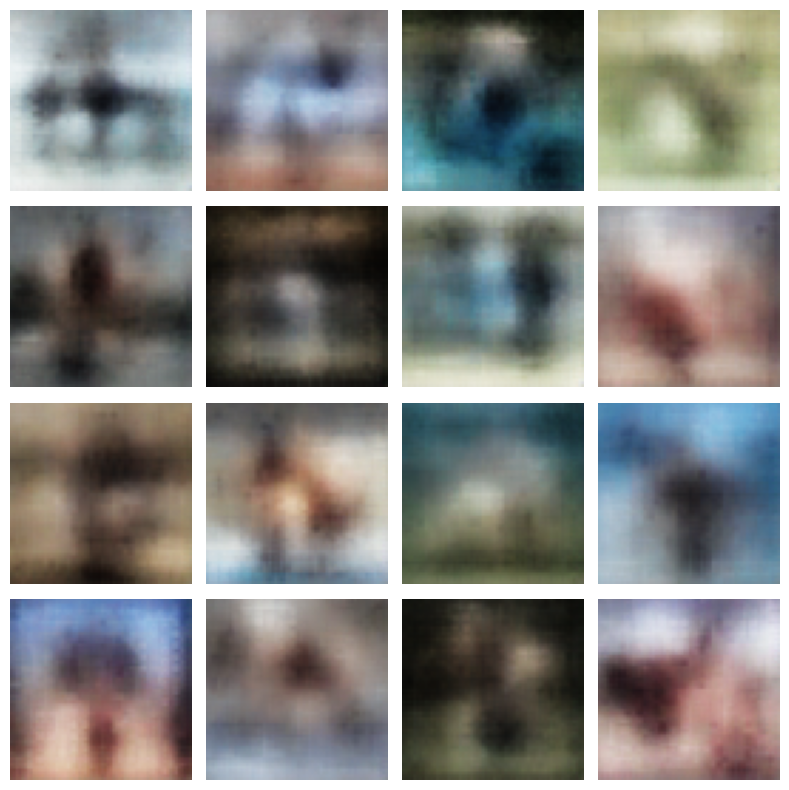

In [ ]:
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

image_size = 64

class VAE(nn.Module):
    def __init__(self, latent_dim=32, reduced_size=16):
        super(VAE, self).__init__()
        # Encoder
        self.red_sz = reduced_size
        self.enc_conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(64*self.red_sz*self.red_sz, latent_dim)
        self.fc_logvar = nn.Linear(64*self.red_sz*self.red_sz, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 64*self.red_sz*self.red_sz)
        self.dec_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, 2, 1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.enc_conv(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 64, self.red_sz, self.red_sz)
        return self.dec_conv(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Data transforms & loading
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
])

train = ImageFolder(path + '/train', transform=transform)
test = ImageFolder(path + '/test', transform=transform)
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32)

num_classes = len(train.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Train loop
vae = VAE(latent_dim=32, reduced_size=int(image_size/4)).to(device)
optimizer_vae = optim.Adam(vae.parameters(), lr=0.001)
num_epochs = 20


for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer_vae.zero_grad()
        recon, mu, logvar = vae(images)
        loss = vae_loss(recon, images, mu, logvar)
        loss.backward()
        optimizer_vae.step()
        train_loss += loss.item()
    print(f'[VAE] Epoch {epoch+1}: Loss = {train_loss/len(train):.4f}')

# Now try generating some images
vae.eval()
with torch.no_grad():
    # Generate 16 random latent vectors
    z = torch.randn(16, 32).to(device)
    generated_images = vae.decode(z)

# Move images to CPU and reformat them
generated_images = generated_images.cpu().permute(0, 2, 3, 1)

# Plot images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for idx, ax in enumerate(axes.flat):
    ax.imshow(generated_images[idx].numpy())
    ax.axis('off')
plt.tight_layout()
plt.show()

Unfortunately was not able to get good results with VAE. I tried to modify parameters and even reduced image size but was not able to get results that look decent. At least the images you can see above look like they are supposed to be SOMETHING just a very blurry something. I was glad at least it wasn't just noise.

Using device: cuda
[GAN] Epoch 1: D Loss = 0.0368, G Loss = 7.4325
[GAN] Epoch 2: D Loss = 0.0271, G Loss = 6.9923
[GAN] Epoch 3: D Loss = 0.1105, G Loss = 8.8512
[GAN] Epoch 4: D Loss = 0.0061, G Loss = 8.6794
[GAN] Epoch 5: D Loss = 0.0002, G Loss = 14.9040
[GAN] Epoch 6: D Loss = 0.0071, G Loss = 10.2144
[GAN] Epoch 7: D Loss = 0.0787, G Loss = 7.4052
[GAN] Epoch 8: D Loss = 0.0071, G Loss = 11.5860
[GAN] Epoch 9: D Loss = 0.0063, G Loss = 6.5924
[GAN] Epoch 10: D Loss = 0.0005, G Loss = 8.6505
[GAN] Epoch 11: D Loss = 0.2616, G Loss = 5.0174
[GAN] Epoch 12: D Loss = 0.0001, G Loss = 22.2648
[GAN] Epoch 13: D Loss = 0.2617, G Loss = 9.5204
[GAN] Epoch 14: D Loss = 0.2700, G Loss = 5.9468
[GAN] Epoch 15: D Loss = 0.0062, G Loss = 10.8756
[GAN] Epoch 16: D Loss = 0.7076, G Loss = 6.2744
[GAN] Epoch 17: D Loss = 0.0224, G Loss = 9.4330
[GAN] Epoch 18: D Loss = 0.2428, G Loss = 7.5547
[GAN] Epoch 19: D Loss = 0.0094, G Loss = 8.8363
[GAN] Epoch 20: D Loss = 0.0342, G Loss = 7.0602


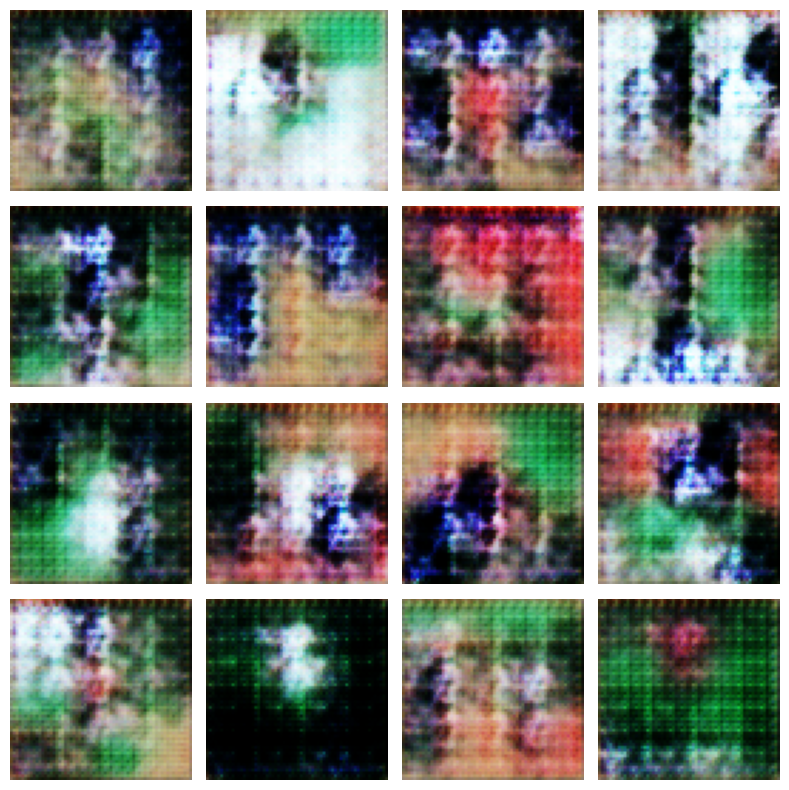

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Updated transform to resize images to 64x64
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Example dataset loading (update 'path' as needed)
train = datasets.ImageFolder(path + '/train', transform=transform)
test = datasets.ImageFolder(path + '/test', transform=transform)
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32)

# Generator for 64x64 images
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: latent vector reshaped to (latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0),  # -> (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # -> (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # -> (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # -> (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),     # -> (3, 64, 64)
            nn.Sigmoid()
        )

    def forward(self, z):
        # Reshape latent vector to (batch_size, latent_dim, 1, 1)
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.net(z)

# Discriminator for 64x64 images
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # -> (64, 32, 32)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # -> (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # -> (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # -> (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),    # -> (1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)

# Set device and instantiate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

latent_dim = 100
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)

criterion_gan = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

# GAN training loop
num_epochs = 20
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)
        batch_size = images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator on real images
        D.zero_grad()
        outputs = D(images)
        loss_real = criterion_gan(outputs, real_labels)

        # Generate fake images and train Discriminator on them
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        loss_fake = criterion_gan(outputs, fake_labels)
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator: aim to fool the Discriminator
        G.zero_grad()
        outputs = D(fake_images)
        loss_G = criterion_gan(outputs, real_labels)
        loss_G.backward()
        optimizer_G.step()

    print(f'[GAN] Epoch {epoch+1}: D Loss = {loss_D.item():.4f}, G Loss = {loss_G.item():.4f}')

# Generate and visualize some images
G.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    generated_images = G(z)

generated_images = generated_images.cpu().permute(0, 2, 3, 1)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for idx, ax in enumerate(axes.flat):
    ax.imshow(generated_images[idx].numpy())
    ax.axis('off')
plt.tight_layout()
plt.show()


The results from GAN were also not satisfactory but they at least also looked like they were on the verge of being close to something. Neither generative models were sufficient. I blame this on having to make a smaller model and my low compute power :)

# **Task 3**

In [ ]:
# Part 1, No deep learning libary just np
def scaled_dot_product_attention(Q, K, V):
    d_k = Q.shape[-1]
    scores = np.dot(Q, K.T) / np.sqrt(d_k)
    # Softmax
    weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    weights = weights / np.sum(weights, axis=-1, keepdims=True)
    output = np.dot(weights, V)
    return output

In [ ]:
    !pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.0 MB/s eta 0:00:00


In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# NOTE HAD TO REIMPLMENT USING PYTORCH FUNCTIONS SO IT IS EFFICIENT WITH FOLLOWING CODE
def scaled_dot_product_attention_T(Q, K, V):
    d_k = Q.shape[-1]
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, V)
    return output, attn_weights


# Encoder using bidirectional RNN
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, batch_first=True, bidirectional=True)

    def forward(self, src):
        embedded = self.embedding(src)
        enc_outputs, hidden = self.rnn(embedded)
        return enc_outputs, hidden

# Decoder with Scaled Dot-Product Attention
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)

        # We'll map the encoder outputs (K, V) and the decoder hidden (Q) to the same dimension
        self.W_q = nn.Linear(dec_hid_dim, dec_hid_dim)
        self.W_k = nn.Linear(enc_hid_dim*2, dec_hid_dim)
        self.W_v = nn.Linear(enc_hid_dim*2, dec_hid_dim)

        self.rnn = nn.GRU(enc_hid_dim + emb_dim, dec_hid_dim, batch_first=True)
        self.fc_out = nn.Linear(dec_hid_dim, output_dim)

    def forward(self, input_token, hidden, enc_outputs):
        # Embed current token
        embedded = self.embedding(input_token).unsqueeze(1)

        # We'll form K, V from enc_outputs, and Q from hidden (the last dec state)
        batch_size, src_len, _ = enc_outputs.size()
        dec_hidden = hidden[-1]

        # Project Q, K, V
        Q = self.W_q(dec_hidden).unsqueeze(1)
        K = self.W_k(enc_outputs)
        V = self.W_v(enc_outputs)

        # Scaled dot-product attention
        # We want Q to have shape [B, 1, d_model], K/V => [B, src_len, d_model]
        context, _ = scaled_dot_product_attention_T(Q, K, V)

        # Concatenate context with embedding for RNN input
        rnn_input = torch.cat((embedded, context), dim=2)

        # Pass through GRU
        output, hidden = self.rnn(rnn_input, hidden)

        # Predict next token
        preds = self.fc_out(output.squeeze(1))

        return preds, hidden

# Full Seq2Seq Model Tying It Together
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        batch_size, trg_len = trg.size()
        # 1) Encode
        enc_outputs, enc_hidden = self.encoder(src)

        # 2) We'll form initial decoder hidden by adding forward/backward top states
        dec_hidden = enc_hidden.sum(dim=0, keepdim=True)

        # Prepare storage for model outputs
        outputs = torch.zeros(batch_size, trg_len, self.decoder.output_dim, device=src.device)

        # We'll feed the first token <sos> in
        input_token = trg[:, 0]

        # 3) Decode step by step
        for t in range(1, trg_len):
            preds, dec_hidden = self.decoder(input_token, dec_hidden, enc_outputs)
            outputs[:, t, :] = preds
            input_token = trg[:, t]

        return outputs

# Next part testing the Seq2Seq Model

import random
from torch.utils.data import DataLoader
from datasets import load_dataset

ds = load_dataset("bentrevett/multi30k", split="train")
# We'll do an 80/20 split from these 29k lines, but only for a small subset to keep it quick:
ds_small = ds.select(range(1000))
split_data = ds_small.train_test_split(test_size=0.2, seed=42)
train_ds = split_data["train"]
test_ds  = split_data["test"]

def simple_tokenize(text):
    return text.lower().split()

all_tokens = []
for item in train_ds:
    all_tokens.extend(simple_tokenize(item['en']))
    all_tokens.extend(simple_tokenize(item['de']))

# Build vocab
vocab = list(set(all_tokens))
vocab2idx = {w:i for i,w in enumerate(vocab, start=3)}
# <sos>=0, <eos>=1, <unk>=2
idx2vocab = {0:"<sos>", 1:"<eos>", 2:"<unk>"}
for w, i in vocab2idx.items():
    idx2vocab[i] = w

def encode(text, max_len=12):
    toks = simple_tokenize(text)
    ids = [0]  # <sos>
    for tk in toks[:max_len-2]:
        ids.append(vocab2idx.get(tk, 2))
    ids.append(1)  # <eos>
    while len(ids) < max_len:
        ids.append(2)  # pad with <unk>
    return ids[:max_len]

def collate_fn(batch):
    src_batch = torch.tensor([encode(x['en']) for x in batch], dtype=torch.long)
    trg_batch = torch.tensor([encode(x['de']) for x in batch], dtype=torch.long)
    return src_batch, trg_batch

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, collate_fn=collate_fn)

input_dim = len(vocab2idx)+3
output_dim = input_dim
emb_dim = 16
hid_dim = 32

encoder = Encoder(input_dim, emb_dim, hid_dim)
decoder = Decoder(output_dim, emb_dim, enc_hid_dim=hid_dim, dec_hid_dim=hid_dim)
model = Seq2Seq(encoder, decoder).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=2)

model.train()
for epoch in range(1, 121):
    total_loss = 0
    for batch_src, batch_trg in train_loader:
        batch_src, batch_trg = batch_src.to(device), batch_trg.to(device)
        optimizer.zero_grad()
        outputs = model(batch_src, batch_trg)
        loss = criterion(
            outputs[:,1:].reshape(-1, model.decoder.output_dim),
            batch_trg[:,1:].reshape(-1)
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_ds)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss = {avg_loss:.3f}")

def greedy_decode(model, src, max_len=12):
    model.eval()
    with torch.no_grad():
        enc_outputs, enc_hidden = model.encoder(src)
        dec_hidden = enc_hidden.sum(dim=0, keepdim=True)
        batch_size = src.size(0)
        input_token = torch.full((batch_size,), 0, dtype=torch.long, device=src.device)  # <sos>=0
        preds_batch = []

        for _ in range(max_len):
            logits, dec_hidden = model.decoder(input_token, dec_hidden, enc_outputs)
            next_token = logits.argmax(dim=-1)
            preds_batch.append(next_token)
            input_token = next_token

    preds_batch = torch.stack(preds_batch, dim=1).cpu().tolist()
    return preds_batch
from nltk.translate.bleu_score import sentence_bleu
import nltk
def evaluate_bleu(model, data_loader):
    model.eval()
    total_bleu = 0
    count = 0
    with torch.no_grad():
        for batch_src, batch_trg in data_loader:
            batch_src, batch_trg = batch_src.to(device), batch_trg.to(device)
            batch_pred = greedy_decode(model, batch_src, max_len=batch_trg.size(1))
            # Compare predicted vs gold
            for i in range(len(batch_src)):
                pred_ids = batch_pred[i]
                gold_ids = batch_trg[i].tolist()
                # Convert to tokens
                pred_toks = [idx2vocab.get(x, "<unk>") for x in pred_ids if x not in [0]]
                gold_toks = [idx2vocab.get(x, "<unk>") for x in gold_ids if x not in [0]]
                # Usually we also strip after <eos>=1, but let's keep it simple
                bleu = sentence_bleu(
                    [gold_toks],
                    pred_toks,
                    smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method1
                )
                total_bleu += bleu
                count += 1
    return total_bleu / max(count,1)

bleu_score = evaluate_bleu(model, test_loader)
print(f"Final BLEU on test set: {bleu_score*100:.2f}")


Using device: cuda
Epoch 20, Loss = 0.460
Epoch 40, Loss = 0.308
Epoch 60, Loss = 0.210
Epoch 80, Loss = 0.153
Epoch 100, Loss = 0.113
Epoch 120, Loss = 0.089
Epoch 140, Loss = 0.070
Epoch 160, Loss = 0.051
Epoch 180, Loss = 0.040
Epoch 200, Loss = 0.036
Final BLEU on test set: 4.01


In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader
from datasets import load_dataset
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def scaled_dot_product_attention_T(Q, K, V):
    d_k = Q.shape[-1]
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, V)
    return output, attn_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=64, n_heads=2):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    def forward(self, Q, K, V, mask=None):
        B, Lq, _ = Q.size()
        B2, Lk, _ = K.size()
        # Project to multi-head
        q = self.W_q(Q).view(B, Lq, self.n_heads, self.d_k).transpose(1,2)
        k = self.W_k(K).view(B2, Lk, self.n_heads, self.d_k).transpose(1,2)
        v = self.W_v(V).view(B2, Lk, self.n_heads, self.d_k).transpose(1,2)
        # Flatten
        Bnh = B * self.n_heads
        q = q.reshape(Bnh, Lq, self.d_k)
        k = k.reshape(Bnh, Lk, self.d_k)
        v = v.reshape(Bnh, Lk, self.d_k)
        out, _ = scaled_dot_product_attention_T(q, k, v)
        out = out.reshape(B, self.n_heads, Lq, self.d_k).transpose(1,2)
        out = out.reshape(B, Lq, self.n_heads*self.d_k)
        out = self.W_o(out)
        return out

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:,0::2] = torch.sin(position*div_term)
        pe[:,1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)

class PositionwiseFF(nn.Module):
    def __init__(self, d_model=64, d_ff=128):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model=64, n_heads=2, d_ff=128):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads)
        self.ff = PositionwiseFF(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
    def forward(self, x):
        a = self.self_attn(x, x, x)
        x = self.norm1(x + a)
        f = self.ff(x)
        x = self.norm2(x + f)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model=64, n_heads=2, d_ff=128):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads)
        self.cross_attn = MultiHeadAttention(d_model, n_heads)
        self.ff = PositionwiseFF(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
    def forward(self, x, enc_out):
        sa = self.self_attn(x, x, x)
        x = self.norm1(x + sa)
        ca = self.cross_attn(x, enc_out, enc_out)
        x = self.norm2(x + ca)
        f = self.ff(x)
        x = self.norm3(x + f)
        return x

class SimplifiedTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=64, n_heads=2, d_ff=128, max_len=5000):
        super().__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_enc_src = PositionalEncoding(d_model, max_len)
        self.pos_enc_tgt = PositionalEncoding(d_model, max_len)
        self.enc1 = EncoderLayer(d_model, n_heads, d_ff)
        self.enc2 = EncoderLayer(d_model, n_heads, d_ff)
        self.dec1 = DecoderLayer(d_model, n_heads, d_ff)
        self.dec2 = DecoderLayer(d_model, n_heads, d_ff)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.d_model = d_model
    def encode(self, src):
        e = self.src_emb(src)*math.sqrt(self.d_model)
        e = self.pos_enc_src(e)
        e = self.enc1(e)
        e = self.enc2(e)
        return e
    def decode(self, tgt, enc_out):
        d = self.tgt_emb(tgt)*math.sqrt(self.d_model)
        d = self.pos_enc_tgt(d)
        d = self.dec1(d, enc_out)
        d = self.dec2(d, enc_out)
        return d
    def forward(self, src, tgt):
        enc_out = self.encode(src)
        dec_out = self.decode(tgt, enc_out)
        return self.fc_out(dec_out)

ds = load_dataset("bentrevett/multi30k", split="train")
ds_small = ds.select(range(2000))
split_data = ds_small.train_test_split(test_size=0.2, seed=42)
train_ds = split_data["train"]
test_ds  = split_data["test"]

def simple_tokenize(text):
    return text.lower().split()

all_tokens = []
for item in train_ds:
    all_tokens.extend(simple_tokenize(item['en']))
    all_tokens.extend(simple_tokenize(item['de']))

vocab = list(set(all_tokens))
vocab2idx = {w:i for i,w in enumerate(vocab, start=3)}
idx2vocab = {0:"<sos>", 1:"<eos>", 2:"<unk>"}
for w,i in vocab2idx.items():
    idx2vocab[i] = w

def encode(text, max_len=12):
    toks = simple_tokenize(text)
    ids = [0]
    for tk in toks[:max_len-2]:
        ids.append(vocab2idx.get(tk,2))
    ids.append(1)
    while len(ids)<max_len:
        ids.append(2)
    return ids[:max_len]

def collate_fn(batch):
    src_batch = torch.tensor([encode(x['en']) for x in batch], dtype=torch.long)
    trg_batch = torch.tensor([encode(x['de']) for x in batch], dtype=torch.long)
    return src_batch, trg_batch

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, collate_fn=collate_fn)

input_dim = len(vocab2idx)+3
output_dim= input_dim
model = SimplifiedTransformer(input_dim, output_dim, 64, 2, 128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion=nn.CrossEntropyLoss(ignore_index=2)

for epoch in range(1,40):
    model.train()
    total_loss=0
    for src_batch,trg_batch in train_loader:
        src_batch,trg_batch=src_batch.to(device),trg_batch.to(device)
        optimizer.zero_grad()
        logits=model(src_batch,trg_batch)
        loss=criterion(logits[:,1:].reshape(-1,logits.size(-1)),trg_batch[:,1:].reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
    if epoch%10==0:
        print(f"Epoch {epoch}, Loss={total_loss/len(train_ds):.3f}")

nltk.download('punkt')

def greedy_decode_t(model, src_single, max_len=12):
    model.eval()
    preds = torch.zeros(1, max_len, dtype=torch.long, device=src_single.device)
    with torch.no_grad():
        enc_out = model.encode(src_single)
        preds[0,0] = 0
        for t in range(1, max_len):
            partial = preds[:,:t]
            dec_out = model.decode(partial, enc_out)
            logits = model.fc_out(dec_out)
            nexttok = logits[:, -1, :].argmax(dim=-1)
            preds[:,t] = nexttok
    return preds[0].tolist()

def test_bleu(model, loader, idx2vocab):
    model.eval()
    total_bleu = 0
    count = 0
    for src_batch, tgt_batch in loader:
        src_batch, tgt_batch = src_batch.to(device), tgt_batch.to(device)
        batch_size=src_batch.size(0)
        for i in range(batch_size):
            src_single = src_batch[i:i+1]
            gold_ids = tgt_batch[i].tolist()
            pred_ids = greedy_decode_t(model, src_single)
            pred_toks=[idx2vocab.get(x,"<unk>")for x in pred_ids if x!=0]
            gold_toks=[idx2vocab.get(x,"<unk>")for x in gold_ids if x!=0]
            b = sentence_bleu([gold_toks], pred_toks,
                              smoothing_function=SmoothingFunction().method1)
            total_bleu+=b
            count+=1
    sc=total_bleu/count
    print(f"Test BLEU={sc*100:.2f}")
    return sc

bleu_score = test_bleu(model, test_loader, idx2vocab)
print(f"Final BLEU on test set: {bleu_score*100:.2f}")


Epoch 10, Loss=0.002
Epoch 20, Loss=0.000
Epoch 30, Loss=0.000


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Test BLEU=0.01
Final BLEU on test set: 0.01


Not sure why the transformer model reported a very low bleu score spent a long time on it. It did however converge much faster than the Seq2Seq model. The training time was much shorter for the transformer model as well. It overall seemed way better except for the bleu score but not sure if that was a me problem.

# **Grad Task**

Polyp segmentation in colonoscopy images is an essential research topic in healthcare because detecting and localizing polyps early can significantly enhance patient outcomes. Models built on U-Net architectures (e.g., U-Net, U-Net++, ResUNet) have become the gold standard for this task, thanks to their effective encoder-decoder design with skip connections. Evaluations typically use the Dice Similarity Coefficient (DSC) and Intersection over Union (IoU), and state-of-the-art approaches (e.g., PraNet) often achieve DSC values above 0.90 on CVC-ClinicDB, while more basic U-Net implementations usually yield slightly lower but still competitive scores (0.80–0.85 DSC range).

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import os
import tifffile as tiff


# Class for loading dataset
class PolypDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        # Read with tifffile, convert to PIL
        img_array = tiff.imread(img_path)
        image = Image.fromarray(img_array).convert("RGB")

        mask_array = tiff.imread(mask_path)
        mask = Image.fromarray(mask_array).convert("L")

        # Apply the same transformations if defined
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        mask = (mask > 0).float()
        return image, mask

# Two conv passes with BN and ReLu
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder
        self.conv_down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv_down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv_down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv_down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv_bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv_up4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_up3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_up2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_up1 = DoubleConv(128, 64)

        self.conv_last = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        c1 = self.conv_down1(x)
        p1 = self.pool1(c1)
        c2 = self.conv_down2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv_down3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv_down4(p3)
        p4 = self.pool4(c4)

        # Bottleneck
        bottleneck = self.conv_bottleneck(p4)

        # Decoder
        u4 = self.up4(bottleneck)
        merge4 = torch.cat([u4, c4], dim=1)
        c5 = self.conv_up4(merge4)
        u3 = self.up3(c5)
        merge3 = torch.cat([u3, c3], dim=1)
        c6 = self.conv_up3(merge3)
        u2 = self.up2(c6)
        merge2 = torch.cat([u2, c2], dim=1)
        c7 = self.conv_up2(merge2)
        u1 = self.up1(c7)
        merge1 = torch.cat([u1, c1], dim=1)
        c8 = self.conv_up1(merge1)

        out = self.conv_last(c8)
        return out


# Train loop
def train_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_images, val_masks in val_loader:
                val_images, val_masks = val_images.to(device), val_masks.to(device)
                val_outputs = model(val_images)
                loss_val = criterion(val_outputs, val_masks)
                val_loss += loss_val.item() * val_images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss   = val_loss / len(val_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

train_dataset = PolypDataset("CVC-ClinicDB/Original", "CVC-ClinicDB/Ground_Truth", transform=transform)
# Split train into train and val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_loader  = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader    = DataLoader(val_ds, batch_size=8, shuffle=False)

model = UNet(in_channels=3, out_channels=1)
trained_model = train_model(model, train_loader, val_loader, num_epochs=10)

Epoch [1/10], Loss: 0.3371, Val Loss: 0.2751
Epoch [2/10], Loss: 0.2396, Val Loss: 0.2799
Epoch [3/10], Loss: 0.2299, Val Loss: 0.2590
Epoch [4/10], Loss: 0.2177, Val Loss: 0.2408
Epoch [5/10], Loss: 0.2121, Val Loss: 0.2219
Epoch [6/10], Loss: 0.1960, Val Loss: 0.2095
Epoch [7/10], Loss: 0.1822, Val Loss: 0.1957
Epoch [8/10], Loss: 0.1775, Val Loss: 0.2142
Epoch [9/10], Loss: 0.1705, Val Loss: 0.1902
Epoch [10/10], Loss: 0.1637, Val Loss: 0.1774


In [23]:
def compute_metrics(preds, targets, threshold=0.5):
    preds_bin = (preds > threshold).float()
    targets_bin = (targets > 0.5).float()

    preds_flat = preds_bin.view(preds_bin.size(0), -1)
    targets_flat = targets_bin.view(targets_bin.size(0), -1)

    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = (preds_flat + targets_flat).sum(dim=1) - intersection

    dice = (2.0 * intersection) / (preds_flat.sum(dim=1) + targets_flat.sum(dim=1) + 1e-8)
    iou = intersection / (union + 1e-8)

    TP = intersection
    FP = preds_flat.sum(dim=1) - intersection
    FN = targets_flat.sum(dim=1) - intersection

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return {
        'dice': dice.mean().item(),
        'iou': iou.mean().item(),
        'precision': precision.mean().item(),
        'recall': recall.mean().item(),
        'f1': f1.mean().item()
    }

def evaluate_model(model, data_loader):
    """
    Runs inference on the given data loader and computes final segmentation metrics.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # We'll accumulate metrics across batches
    metric_sums = {'dice': 0.0, 'iou': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    num_batches = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            # Convert logit outputs to probabilities
            probs = torch.sigmoid(outputs)

            # Compute metrics for this batch
            metrics_dict = compute_metrics(probs, masks)
            for key in metric_sums:
                metric_sums[key] += metrics_dict[key]
            num_batches += 1

    # Average over all batches
    for key in metric_sums:
        metric_sums[key] /= num_batches

    return metric_sums

evaluate_model(model, val_loader)

{'dice': 0.5189077295362949,
 'iou': 0.4114278592169285,
 'precision': 0.5789252612739801,
 'recall': 0.5679665189236403,
 'f1': 0.5189077258110046}

We can conclude that U-net is a way forward for this task, but my model was unable to get state of the art results due to lack of GPU support. We can compare our results to DUCK-Net. DUCK-Net achieved a dice of 0.9684 and IoU of 0.9343. This model is the state of the art and we were very far from it. On the other hand the U-Net++ was closer to our results only achieving a dice of 0.7940.